# Tutorial: Using AION-1 on Stellar Tasks

Authors:
  - [@lhparker1](https://github.com/lhparker1) (Liam H. Parker)
  - [@al-jshen](https://github.com/al-jshen) (Jeff Shen)
  - [@EiffL](https://github.com/EiffL) (Francois Lanusse)
  - [@ltmeyer](https://github.com/ltmeyer) (Lucas Meyer)


In this notebook, we will explore how to use **AION-1**, to tackle two specific tasks:

1. **Stellar Spectrum Super-Resolution**: Enhancing the resolution of low-resolution Gaia BP/RP coefficients with AION-1's generative capabilities.
2. **Lightweight Stellar Property Prediction**: Estimating stellar properties such as effective temperature, surface gravity, and metallicity from AION-1's embeddings of Gaia BP/RP coefficients.

By the end of this notebook, you will gain insights into how AION-1 can be applied to real-world astronomical datasets and learn how to leverage its capabilities for stellar astrophysics.


---
### 🔽 Downloading demo datasets

In [2]:
# Downloading a bunch of data (takes a few minutes)
!wget https://users.flatironinstitute.org/~lparker/gaia_apogee.fits
!wget https://users.flatironinstitute.org/~lparker/gaia_desi.fits

## Stellar Spectrum Super-Resolution

To generate high-resolution spectra from low-resolution Gaia BP/RP coefficients, we use AION-1 to artificially generate the DESI spectrum of a star conditioned on its Gaia BP/RP coefficients. Concretely, this process involves the following steps:

1. **Encoding Gaia BP/RP Coefficients**: 
    The homogenized Gaia BP/RP coefficients (`gaia_xp_bp` and `gaia_xp_rp`) are encoded into tokens using the `codec_manager`.

2. **Model Inference**:
    The encoded tokens are passed to the AION model along with the target modality (`DESISpectrum`). The model processes the input tokens and generates tokens corresponding to the DESI spectra.

3. **DESI spectrum decoding**:
    We decode the DESI tokens produced by the AION model into a predicted DESI spectrum with the decoding function of the DESI codec, once against handled through the `codec_manager`.

This workflow enables conditional sampling from AION, allowing us to generate DESI spectrum tokens based on Gaia BP/RP coefficients.

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

# Load the data
data = Table.read('gaia_desi.fits')

# Get DESI spectra
mask = np.array(data['desi_spectrum_mask'])
wavelength = np.array(data['desi_spectrum_lambda'])
spectra = np.array(data['desi_spectrum_flux'])

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


We will first preprocess the Gaia BP/RP coefficients from the loaded dataset to make them compatible with AION-1. This involves homogenizing the coefficients and creating objects that can be used with AION-1's modalities.

In [4]:
from aion.modalities import (GaiaXpBp, GaiaXpRp, DESISpectrum)

# Homogenize the Gaia BP/RP coefficients
gaia_xp_bp = torch.tensor(data['gaia_bp_coefficients'].astype("float32")).to("cuda")
gaia_xp_rp = torch.tensor(data['gaia_rp_coefficients'].astype("float32")).to("cuda")

# Create the GaiaXpBp and GaiaXpRp objects for AION-1
gaia_xp_bp = GaiaXpBp(gaia_xp_bp)
gaia_xp_rp = GaiaXpRp(gaia_xp_rp)
gaia_xp_bp, gaia_xp_rp

(GaiaXpBp(shape=[1, 55]), GaiaXpRp(shape=[1, 55]))

Once homogenized, we then use the appropriate codec to tokenize the coefficients for ingestion into the AION-1 model.

In [5]:
from aion.codecs import CodecManager

# Instantiate the manager
codec_manager = CodecManager(device="cuda")

# Apply a codec on our prepared gaia bp/rp coefficients
# This will automatically download the necessary codec
tokens = codec_manager.encode(gaia_xp_bp, gaia_xp_rp)

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [6]:
from aion.model import AION

# Disable gradients for this notebook
torch.set_grad_enabled(False)

# Importing model
model = AION.from_pretrained("polymathic-ai/aion-base").to("cuda").eval()

In [7]:
# Get logits output from the model
logits = model(
    tokens, 
    target_modality=DESISpectrum
)

In [8]:
# Get the token key for the DESI spectrum
token_key = DESISpectrum.token_key

# Get the predicted token by taking the argmax of the logits
pred_token = {token_key: logits[token_key].softmax(dim=-1).argmax(dim=-1)} # B x tokens

In [9]:
# Use the codec manager to decode the predicted tokens
pred_spectra = codec_manager.decode(pred_token, DESISpectrum, wavelength=torch.tensor(wavelength.astype(np.float32)).cuda())
pred_flux = pred_spectra.flux.cpu().numpy()

Text(0.5, 1.0, 'DESI Spectrum vs AION-1 Prediction from Gaia')

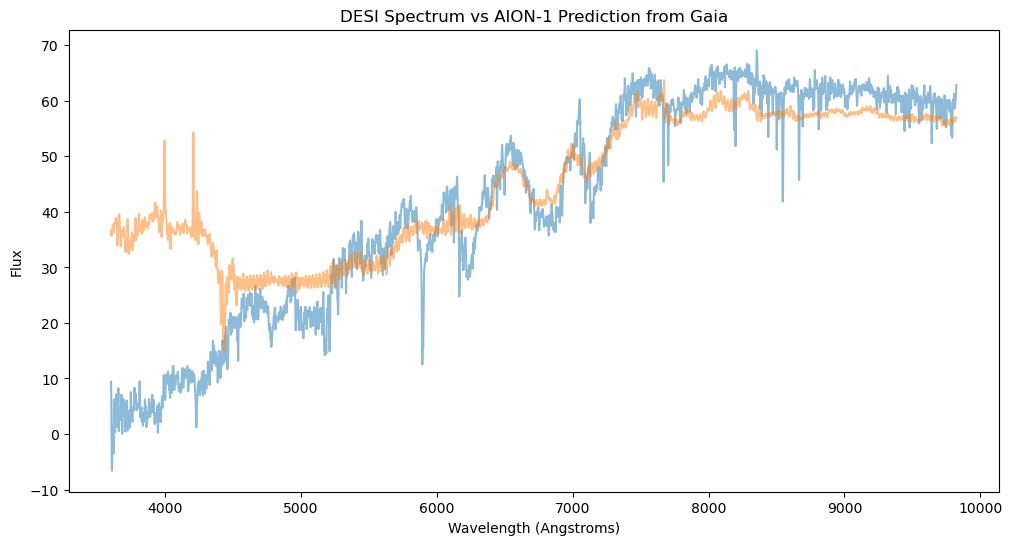

In [10]:
from scipy.ndimage import gaussian_filter1d

w = wavelength[~mask]
desi_spectrum = spectra[~mask]
pred_spectrum = pred_flux[~mask]

# Plot the spectra
plt.figure(figsize=(12, 6))
plt.plot(w, gaussian_filter1d(desi_spectrum, 2), label="DESI Spectrum", alpha=0.5)
plt.plot(w, gaussian_filter1d(pred_spectrum, 2), label="AION Prediction", alpha=0.5)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux")
plt.title("DESI Spectrum vs AION-1 Prediction from Gaia")

## Lightweight Stellar Property Prediction
Lightweight Stellar Property Prediction involves leveraging AION-1's embeddings of Gaia BP/RP coefficients to estimate stellar properties such as effective temperature, surface gravity, and metallicity. This process includes the following steps:

1. **Embedding Extraction**: 
    The Gaia BP/RP coefficients are encoded into tokens using the `codec_manager`. These tokens are passed through the AION-1 model to generate embeddings that represent the stellar properties.

2. **Mean Pooling**:
    The embeddings are mean-pooled to create a compact representation of the stellar properties.

3. **Training a Projection Matrix**:
    A simple projection matrix, such as a linear regression model, is trained using the pooled embeddings to predict stellar properties.

Once trained, we can then use the lightweight projection head to make predictions on Gaia embeddings from a held-out test set

In [35]:
# Load the data
data = Table.read('gaia_apogee.fits')

# Homogenize the Gaia BP/RP coefficients
gaia_xp_bp = torch.tensor(data['bp_coefficients'].astype("float32")).to("cuda")
gaia_xp_rp = torch.tensor(data['rp_coefficients'].astype("float32")).to("cuda")
num_tokens = GaiaXpBp.num_tokens + GaiaXpRp.num_tokens

# Get the stellar parameters derived from cross-matched APOGEE spectra
teff = np.array(data['teff50'])
logg = np.array(data['logg50'])
met = np.array(data['met50'])
targets = np.array([teff, logg, met]).T

Here, we do mean pooling of the embeddings of the model

In [34]:
from tqdm import tqdm

batch_size = 64
aion_embeddings = []

# Loop over the data in batches
for i in tqdm(range(0, len(gaia_xp_bp), batch_size), desc="Processing batches"):
    # Get the current batch
    gaia_xp_bp_batch = GaiaXpBp(gaia_xp_bp[i:i+batch_size])
    gaia_xp_rp_batch = GaiaXpRp(gaia_xp_rp[i:i+batch_size])

    # Apply a codec on our prepared gaia bp/rp coefficients
    tokens = codec_manager.encode(gaia_xp_bp_batch, gaia_xp_rp_batch)

    # Get the embeddings output from the model
    embeddings = model.encode(tokens, num_encoder_tokens = num_tokens)
    embeddings_pooled = torch.mean(embeddings, dim=1) # B x tokens x hidden_dim -> B x hidden_dim

    # Store the embeddings
    aion_embeddings.append(embeddings_pooled.cpu())

aion_embeddings = torch.cat(aion_embeddings, dim=0)
print(f"Successfully processed {len(data)} images in batches of {batch_size}.")
print(f"Embeddings shape: {aion_embeddings.shape}")

Processing batches:   0%|          | 0/36 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 36/36 [00:04<00:00,  8.05it/s]

Successfully processed 2280 images in batches of 64.
Embeddings shape: torch.Size([2280, 768])


In [41]:
# Set up a training and test split
randperm = torch.randperm(len(aion_embeddings))
train_size = int(0.8 * len(randperm))
train_ix = randperm[:train_size]
test_ix = randperm[train_size:]

train_x, test_x = aion_embeddings[train_ix], aion_embeddings[test_ix]
train_y, test_y = targets[train_ix], targets[test_ix]

In [43]:
# Fit a simple projection matrix
from sklearn.linear_model import LinearRegression

adapter = LinearRegression(n_jobs=-1)
%time adapter.fit(train_x, train_y)

CPU times: user 871 ms, sys: 38.9 ms, total: 909 ms
Wall time: 115 ms


LinearRegression(n_jobs=-1)

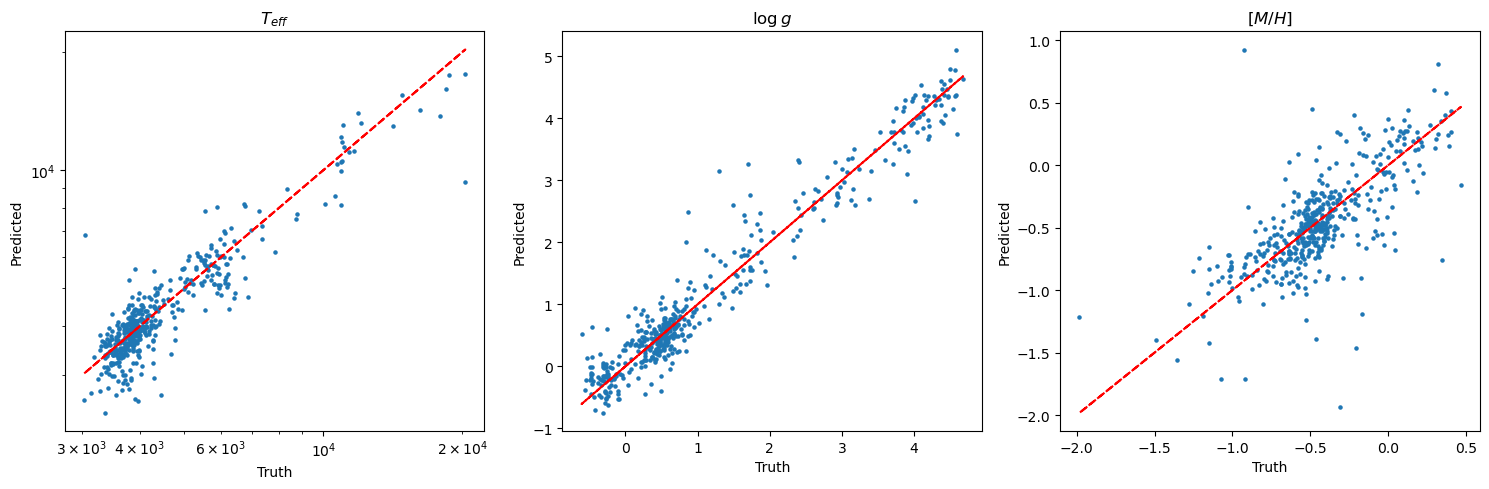

In [48]:
# Check and plot predictions
pred_y = adapter.predict(test_x)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

titles = [r'$T_{eff}$', r'$\log g$', r'$[M/H]$']

for i, j in enumerate(titles):
    ax[i].scatter(test_y[:,i], pred_y[:,i], s=5)
    ax[i].plot(test_y[:,i], test_y[:,i], 'r--')
    ax[i].set_title(j)
    ax[i].set_xlabel("Truth")
    ax[i].set_ylabel("Predicted")
    if i == 0:
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")

plt.tight_layout()
plt.show()